In [1]:
# Installing required packages
%pip install -r requirements.txt
%pip install --upgrade --no-index --find-links=wheelhouse heapcy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: wheelhouse
Note: you may need to restart the kernel to use updated packages.


In [2]:
size_of_heap = 1_000_000
import random
def gen_random_string(le=12)->str:
    alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789~!@#$%^&*-_=+;:\\`"
    random.seed()
    pwd_len= random.randrange(1,le)
    prob = random.uniform(0,1)
    final_str= ""
    for _ in range(pwd_len):
        char= random.randrange(le)
        final_str += alphabet[char]
    return final_str + " "+str(prob)+"\n"

In [3]:
import tempfile
def create_temp_file_for_benchmark()->str:
    tf = tempfile.NamedTemporaryFile(delete=False)
    lis = [ gen_random_string() for _ in range(size_of_heap)]
    with open(tf.name,"w") as f_open:
        f_open.writelines(lis)
    return tf.name
    

In [4]:
import heapq 
from pympler import asizeof
heap = []
tf = create_temp_file_for_benchmark()

with open(tf,"rb") as f_open:
     while True:
        line = f_open.readline()
        if not line:
            break
        parts = line.split(b" ")
        if len(parts) != 2:
            continue

        prob = float(parts[1].decode(encoding="ascii"))

        if len(heap)< size_of_heap:
            heapq.heappush(heap,(prob,parts[0]))
        elif heap[0][0]>prob:
            heapq.heappoppush(heap,(prob,parts[0]))
size_of_heapq=asizeof.asizeof(heap)/1000/1000
print(f"sizeof  heapq = {size_of_heapq}MB")
del heap

sizeof  heapq = 127.721568MB


In [5]:
from heapitem import HeapItem
import heapq
heap = []
with open(tf,"rb") as f_open:
    while True:
        line = f_open.readline()
        if not line:
            break
        parts = line.split(b" ",1)
        
        heapq.heappush(heap,HeapItem(float(parts[1]),parts[0].decode(encoding="ascii")))
size_of_heapitem=asizeof.asizeof(heap)/1000/1000
print(f"sizeof normal heap with heapitem = {size_of_heapitem}MB")
del heap

sizeof normal heap with heapitem = 51.356728000000004MB


In [6]:
import heapcy,os
heap = heapcy.Heap(size_of_heap)
with open(tf,"rb") as f_open:

    while True:
        offset = f_open.tell()
        line = f_open.readline()
        if not line:
            break

        parts = line.split(b" ", 1)
        if len(parts) != 2:
            continue

        prob = float(parts[1].decode(encoding="ascii"))
        if len(heap)< size_of_heap:
            heapcy.heappush(heap,prob,offset)
        elif heapcy.heappeek(heap)[0]>prob:
            heapcy.heappoppush(heap,prob,offset)

size_of_based_heap=asizeof.asizeof(heap)/1000/1000
print(f"sizeof special heap = {size_of_based_heap}MB")
del heap
os.remove(tf)

sizeof special heap = 16.000056MB


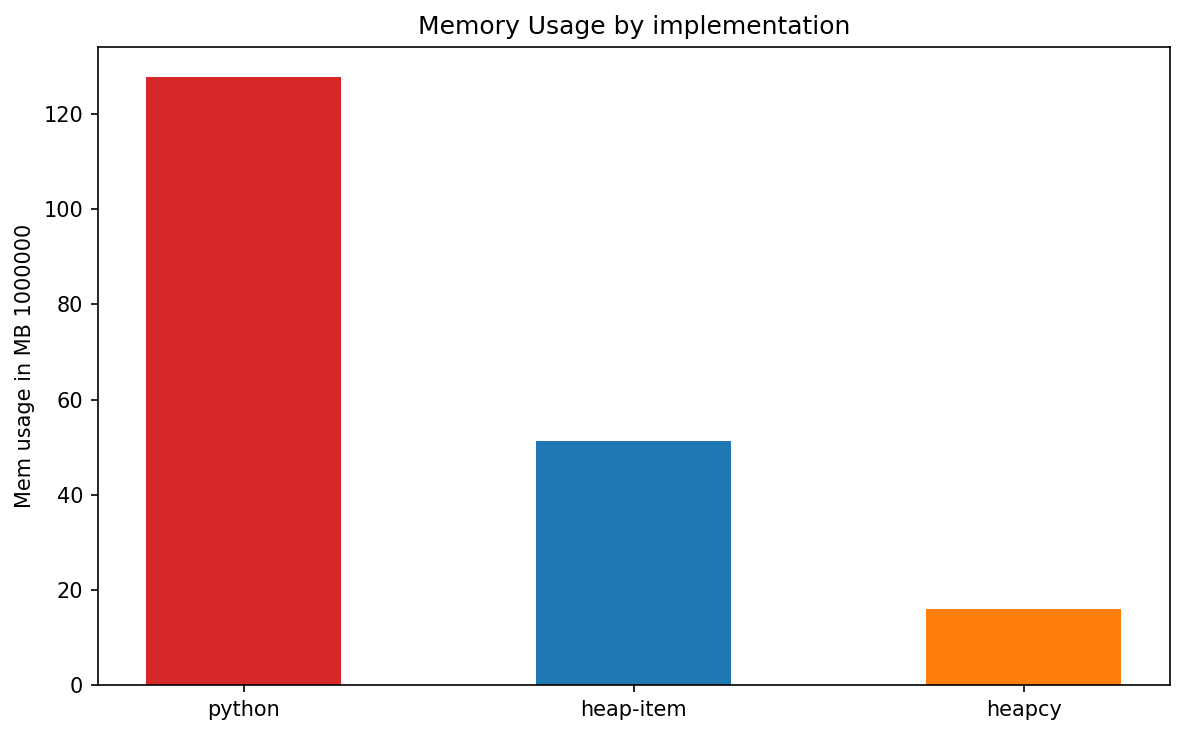

In [7]:
import os, numpy as np
import matplotlib.pyplot as plt

os.makedirs("benchmarks-plot", exist_ok=True)

implementations = ['python', 'heap-item', 'heapcy']
sizes = [size_of_heapq, size_of_heapitem, size_of_based_heap]
colors = ['tab:red', 'tab:blue', 'tab:orange']

x = np.arange(len(implementations))

fig, ax = plt.subplots(figsize=(8, 5), dpi=150)  # smaller, denser figure
ax.bar(x, sizes, width=0.5, color=colors)        # narrower bars
ax.set_xticks(x, implementations)
ax.margins(x=0.05)                                # a little side padding

ax.set_ylabel('Mem usage in MB ' + str(size_of_heap))
ax.set_title('Memory Usage by implementation')
fig.tight_layout()
fig.savefig(f'./benchmarks-plot/benchmark-{size_of_heap}.png', bbox_inches='tight')
plt.show()
